In this file I show the real undersampling error by subtracting noise and compare that to the noisy ground truth vs full rank.

In [1]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from output_statistics import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 

masks = np.load('../data/masks.npy')

grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

Select dataset

In [2]:
AF = 3
Patient = 0

MASK = True ## If true: Apply masks
maks = masks[:,:,:,Patient]

### Load data and tracuate
Ground_Truth_noisy = np.load('../data/Full_Rank_All_trancuated_k_space.npy')[...,Patient]  #combined_trancuated_k_space_low_rank_15
Signal_Estimate = low_rank(Ground_Truth_noisy, 8)

noise_estimate = Ground_Truth_noisy-Signal_Estimate

Undersampled_Full_Rank = np.load(f'../data/Undersampled_Data/combined_undersampled_possoin_3D_fixed_r0_AF_{AF}.npy')[...,Patient]

#### Estimate only aliasing contribution form udnersampling by subtracting noise
Undersampled_Signal_no_noise = Undersampled_Full_Rank - noise_estimate

if MASK:
    Signal_Estimate = Signal_Estimate*maks[:,:,:,np.newaxis,np.newaxis]
    Ground_Truth_noisy = Ground_Truth_noisy*maks[:,:,:,np.newaxis,np.newaxis]
    Undersampled_Signal_no_noise = Undersampled_Signal_no_noise*maks[:,:,:,np.newaxis,np.newaxis]
    
    
Ground_Truth_noisy_spectral =  np.fft.fftshift(np.fft.fft(Ground_Truth_noisy, axis=-2),axes=-2) 
Signal_Estimate_spectral =  np.fft.fftshift(np.fft.fft(Signal_Estimate, axis=-2),axes=-2) 
Undersampled_Signal_no_noise_spectral =  np.fft.fftshift(np.fft.fft(Undersampled_Signal_no_noise, axis=-2),axes=-2) 

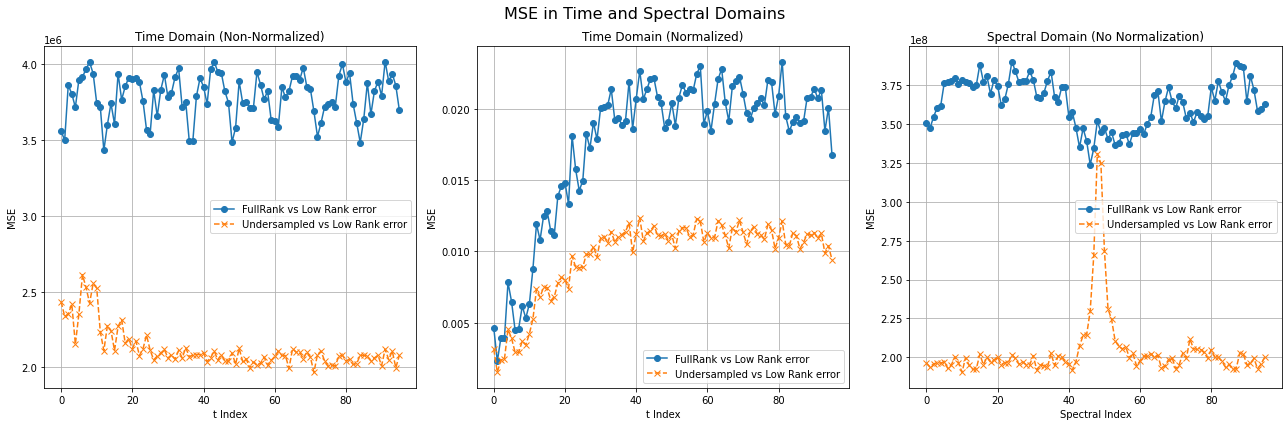

==== Model Output vs Ground Truth ====
Total MSE in image domain: 1893029.1145581312
Normalized Total MSE in image domain: 0.008734123735748953
Total MSE in spectral domain: 181730794.99758056

==== Model Input vs Ground Truth ====
Total MSE in image domain: 1061521.7856705354
Normalized Total MSE in image domain: 0.004816140469069268
Total MSE in spectral domain: 101906091.4243714


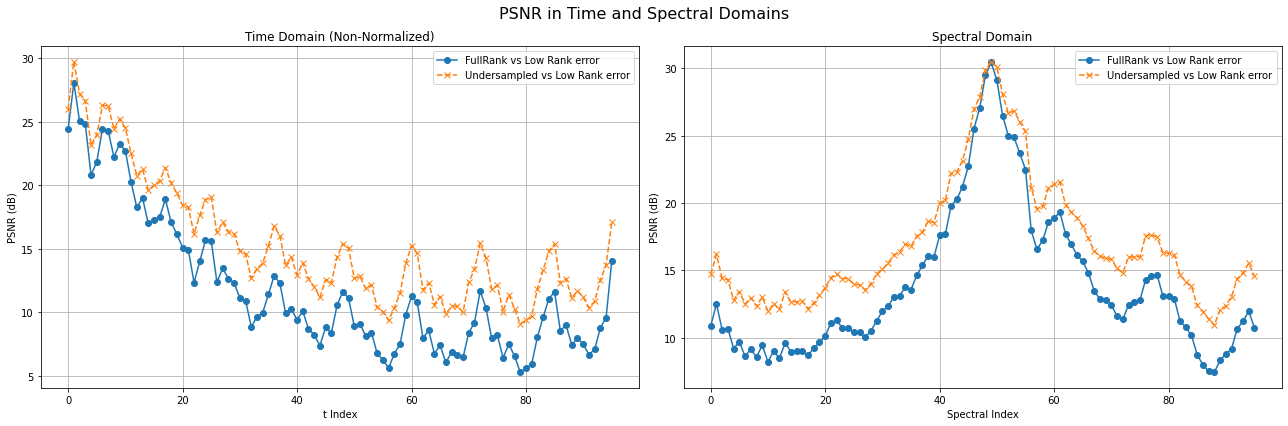

==== Model Output vs. Ground Truth ====
Average PSNR in image domain:    11.875199255377439
Average PSNR in frequency domain: 13.949226164591222

==== Model Input vs. Ground Truth ====
Average PSNR in image domain:    15.325663313621419
Average PSNR in frequency domain: 17.014205756074357


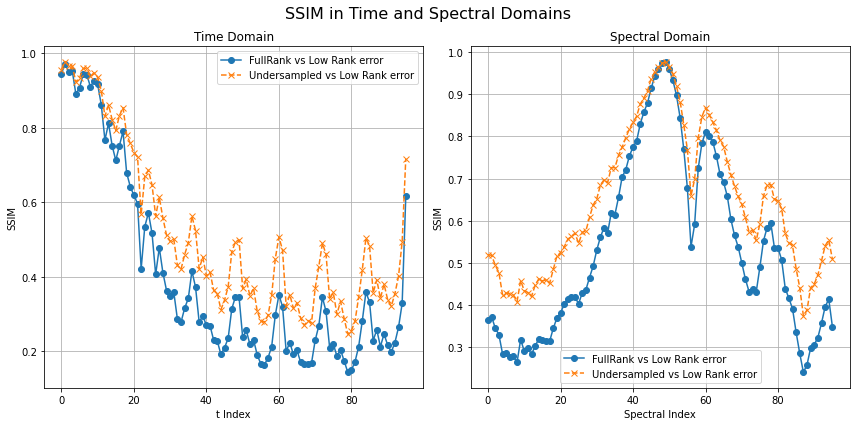

==== Model Output vs. Ground Truth ====
Average SSIM in image domain:    0.40377442946415726
Average SSIM in frequency domain: 0.5342598772315469

==== Model Input vs. Ground Truth ====
Average SSIM in image domain:    0.5184611628309781
Average SSIM in frequency domain: 0.6426389005473273


In [3]:
label ='Undersampled vs Low Rank error'
label2 = 'FullRank vs Low Rank error'

_, _, norm_values_test = normalize_data_per_image_new(Ground_Truth_noisy, Signal_Estimate)

plot_general_statistics(Ground_Truth_noisy, Undersampled_Signal_no_noise, Signal_Estimate, 96, norm_values_test, label2, label)
plot_general_statistics_PSNR(Ground_Truth_noisy, Undersampled_Signal_no_noise, Signal_Estimate, 96, norm_values_test, label2, label)
plot_general_statistics_SSIM(Ground_Truth_noisy, Undersampled_Signal_no_noise, Signal_Estimate, 96, norm_values_test, label2, label)

/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
../scripts/output_statistics.py:279: RuntimeWarning: invalid value encountered in double_scalars
  return calculate_rmse(pred, gt) / (gt.max() - gt.min())


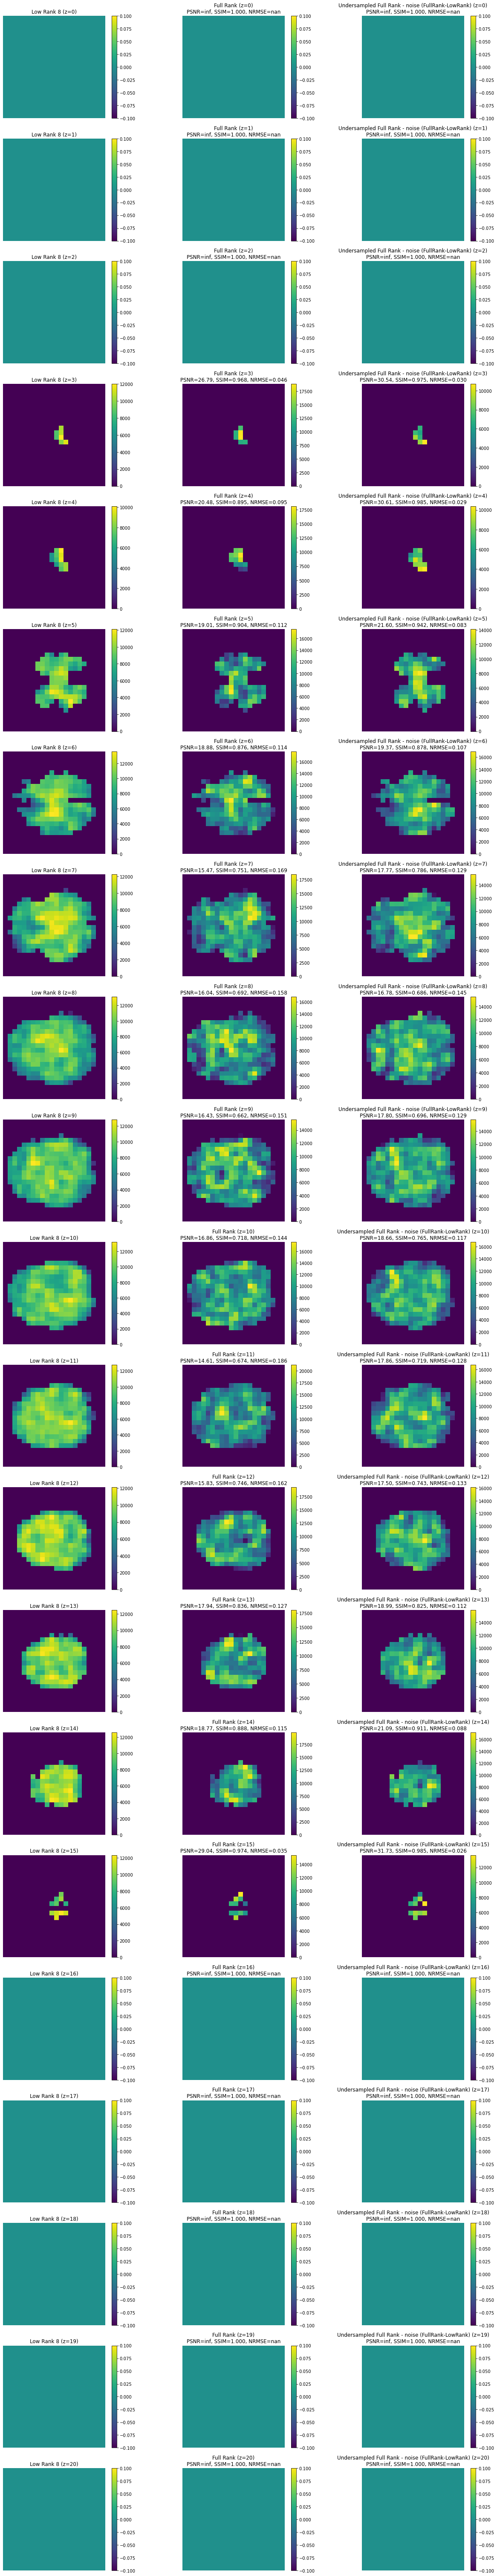

In [5]:
t, T = 1, 7  

t = 4 #50 = water, 60 = Glc
domain ="time" # time or spectral

label="Full Rank"
label2 = "Undersampled Full Rank - noise (FullRank-LowRank)"
label3 = "Low Rank 8"

if domain == "spectral":
    comparison_Plot_3D_vs_Ifft(Ground_Truth_noisy, Signal_Estimate, Undersampled_Signal_no_noise, t, T, domain=domain, label=label, label2=label2, label3=label3)
else:    
    comparison_Plot_3D_vs_Ifft(Ground_Truth_noisy, Signal_Estimate, Undersampled_Signal_no_noise, t, T, domain=domain, label=label, label2=label2, label3=label3)

In [ ]:
Patient = 0
x, y, T = 10, 15, 7

indices = range(6, 15) 
num_rows = len(indices)
num_cols = 1  # left column: arr1 vs arr2; right column: arr3 vs arr4
# Create a figure and a grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4), sharex=True)

# If there's only one row, axs may not be 2D, so ensure we have a 2D array:
if num_rows == 1:
    axs = np.array([axs])

for i, idx in enumerate(indices):
    # Left subplot: compare arr1 and arr2
    ax_left = axs[i,]
    ax_left.plot(np.abs(Ground_Truth_noisy_spectral[x, y, idx, :, T]), label="Fully Sampled")
    ax_left.plot(np.abs(Undersampled_Signal_no_noise_spectral[x, y, idx, :, T]), label=f"Undersampled AF = {AF} without noise")
    ax_left.plot(np.abs(Signal_Estimate_spectral[x, y, idx, :, T]), label=f"Low Rank 8")
    ax_left.set_title(f" z = {idx}")
    ax_left.legend()
    ax_left.legend(loc="upper left")


In [ ]:
AF = 3
Patient = 0
T = 0
Patient = 3

MASK = True ## If true: Apply masks
maks = masks[:,:,:,Patient]

### Load data and tracuate
Ground_Truth_noisy = np.load('../data/Full_Rank_All_trancuated_k_space.npy')[...,Patient]  #combined_trancuated_k_space_low_rank_15
Signal_Estimate = low_rank(Ground_Truth_noisy, 8)

noise_estimate = Ground_Truth_noisy-Signal_Estimate



noise_estimate_abs = np.abs(noise_estimate)
noise_norm = np.sqrt(np.sum(noise_estimate_abs**2, axis=(0, 1, 2)))
noise_norm_average = np.mean(noise_norm, axis=1)

plt.figure(figsize=(8, 4))  # Optional: Adjust figure size
plt.plot(noise_norm_average, marker='o', linestyle='-', label="noise norm")  # Line plot with markers
plt.xlabel("t")
plt.ylabel("noise norm")
plt.title("noise magnitude")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
noise_norm.shape